## Examples using GradientBoostedLowess

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import torch

from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer
from GradientBoostedLowess import GradientBoostedLowess

# Evaluating the model
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error as mse

# Data visualization
import matplotlib.pyplot as plt

In [2]:
seed = 441

### Applying GradientBoostedLowess on Data with 1 Feature

In [7]:
# Simulate data
def true_model(X):
    return 4*np.sin(X) + 5

sample_size = 1000
np.random.seed(seed)

noise = np.random.normal(size=sample_size)
X = torch.Tensor(np.random.uniform(-15, 15, sample_size))
y = torch.Tensor(true_model(X) + noise)

(X.shape, y.shape)

(torch.Size([1000]), torch.Size([1000]))

In [15]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=seed)

scaler = StandardScaler()
Xtrain_scaled = torch.Tensor(scaler.fit_transform(Xtrain.reshape(-1,1)))
Xtest_scaled = torch.Tensor(scaler.transform(Xtest.reshape(-1,1)))

model = GradientBoostedLowess(learning_rate=0.01)
model.fit(Xtrain_scaled, ytrain)

y_pred = model.predict(Xtest_scaled)
print("Mean squared error of predictions:", mse(ytest, y_pred))

Mean squared error of predictions: 1.5606377889086542


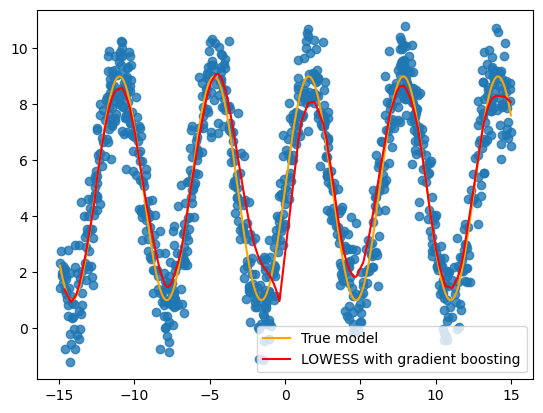

In [16]:
plt.scatter(X, y, alpha=0.8)

sort_idx = X.argsort()
plt.plot(X[sort_idx], true_model(X)[sort_idx], color='orange', label='True model')

sort_idx = Xtest.argsort()
plt.plot(Xtest[sort_idx], y_pred[sort_idx], color='red', label='LOWESS with gradient boosting')

plt.legend(loc='lower right')
plt.show()

### Testing GradientBoostedLowess with Different Scalers on Data with 3 Features

Get cars dataset here: https://gist.github.com/noamross/e5d3e859aa0c794be10b

In [17]:
data = pd.read_csv("cars.csv")
data

,MPG,CYL,ENG,WGT
0,18.0,8,307.0,3504
1,15.0,8,350.0,3693
2,18.0,8,318.0,3436
3,16.0,8,304.0,3433
4,17.0,8,302.0,3449
...,...,...,...,...
387,27.0,4,140.0,2790
388,44.0,4,97.0,2130
389,32.0,4,135.0,2295
390,28.0,4,120.0,2625


In [18]:
X = torch.Tensor(data.drop('MPG', axis=1).values)
y = torch.Tensor(data['MPG'].values)

(X.shape, y.shape)

(torch.Size([392, 3]), torch.Size([392]))

In [6]:
def DoKFold(X, y, model=GradientBoostedLowess(), scaler=StandardScaler()):
    '''
    Perform k-fold validation and return the 
    average mean squared errors of the results.
    '''
    train_mse = []
    test_mse = []

    kf = KFold(n_splits=10)
    for idxTrain, idxTest in kf.split(X, y):
        Xtrain = X[idxTrain]
        Xtest = X[idxTest]
        ytrain = y[idxTrain]
        ytest = y[idxTest]

        Xtrain_scaled = torch.Tensor(scaler.fit_transform(Xtrain))
        Xtest_scaled = torch.Tensor(scaler.transform(Xtest))

        model.fit(Xtrain_scaled, ytrain)

        train_mse.append(mse(ytrain, model.predict(Xtrain_scaled)))
        test_mse.append(mse(ytest, model.predict(Xtest_scaled)))

    return np.mean(train_mse), np.mean(test_mse)

In [21]:
DoKFold(X, y, GradientBoostedLowess(n_estimators=5), StandardScaler())

(8.178383, 91.17631)

In [22]:
DoKFold(X, y, GradientBoostedLowess(n_estimators=5), MinMaxScaler())

(13.238194, 27.26006)

In [23]:
DoKFold(X, y, GradientBoostedLowess(n_estimators=5), QuantileTransformer(n_quantiles=70))

(12.229577, 20.081436)

### Hyperparameter Tuning on Concrete Data

Get concrete dataset here: https://archive.ics.uci.edu/dataset/165/concrete+compressive+strength

In [3]:
data = pd.read_csv('concrete.csv')
data

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30
...,...,...,...,...,...,...,...,...,...
1025,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.28
1026,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28,31.18
1027,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28,23.70
1028,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28,32.77


In [4]:
X = torch.Tensor(data.drop('strength', axis=1).values)
y = torch.Tensor(data['strength'].values)

(X.shape, y.shape)

(torch.Size([1030, 8]), torch.Size([1030]))

In [7]:
n_estimators = [5, 10, 20, 50]
learning_rate = [0.01, 0.1]

# Store mean squared errors for the training and testing data
train_mses = []
test_mses = []

for lr in learning_rate:
    for n in n_estimators:
        print("Performing k-fold cross-validation with learning_rate={} and n_estimators={}".format(lr, n))
        try:
            tr, te = DoKFold(X, y, model=GradientBoostedLowess(learning_rate=lr, n_estimators=n))
            train_mses.append(tr)
            test_mses.append(te)
            print("Success!")
        except:
            print("Failure...")
            train_mses.append(-1)
            test_mses.append(-1)

Performing k-fold cross-validation with learning_rate=0.01 and n_estimators=5
Success!
Performing k-fold cross-validation with learning_rate=0.01 and n_estimators=10
Success!
Performing k-fold cross-validation with learning_rate=0.01 and n_estimators=20
Success!
Performing k-fold cross-validation with learning_rate=0.01 and n_estimators=50
Success!
Performing k-fold cross-validation with learning_rate=0.1 and n_estimators=5
Success!
Performing k-fold cross-validation with learning_rate=0.1 and n_estimators=10
Success!
Performing k-fold cross-validation with learning_rate=0.1 and n_estimators=20
Success!
Performing k-fold cross-validation with learning_rate=0.1 and n_estimators=50
Success!


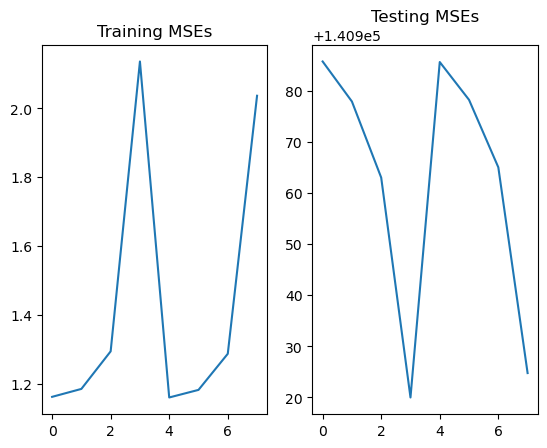

In [50]:
fig, ax = plt.subplots(ncols=2)
ax[0].plot(train_mses)
ax[0].set_title('Training MSEs')
ax[1].plot(test_mses)
ax[1].set_title('Testing MSEs')
plt.show()

In [21]:
# Rows: learning_rate
# Columns: n_estimators
train_mse_matr = torch.Tensor(train_mses).reshape(len(learning_rate), len(n_estimators))
test_mse_matr = torch.Tensor(test_mses).reshape(len(learning_rate), len(n_estimators))
(train_mse_matr, test_mse_matr)

(tensor([[1.1613, 1.1843, 1.2935, 2.1360],
         [1.1594, 1.1815, 1.2865, 2.0364]]),
 tensor([[140985.7812, 140977.9375, 140963.0312, 140919.9531],
         [140985.6719, 140978.2656, 140965.0469, 140924.7344]]))

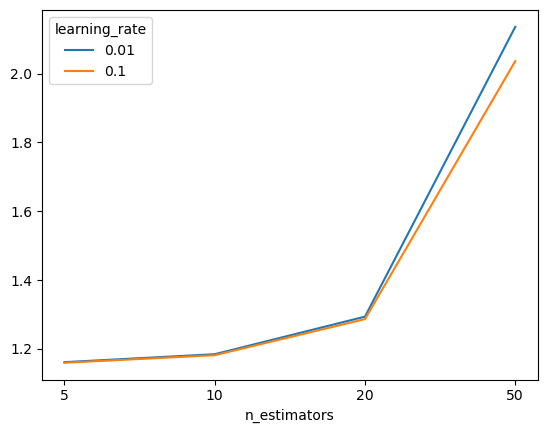

In [65]:
x_labels = [str(val) for val in n_estimators]
for row_idx in range(train_mse_matr.shape[0]):
    plt.plot(x_labels, train_mse_matr[row_idx], label=learning_rate[row_idx])
plt.xlabel('n_estimators')
plt.legend(title='learning_rate')
plt.show()